# Master Pytorch Chapter 4 : Classifier(CIFAR10 dataset)
- http://pytorch.kr/beginner/blitz/cifar10_tutorial.html

## 데이터 다루기
- 이미지나 텍스트, 오디오나 비디오 데이터를 다룬다.
- 표준 python 패키지를 사용하여 불러온 후 numpy배열로 변환
- 그리고 그 배열을 torch.tensor로 변환

### 꿀팁
- 이미지는 Pillow나 OpenCV 패키지(Pillow - 과거 PIL)
- 영상 분야에서는 **torchvision** 패키지가 따로 있어서 좋음
- 오디오 처리는 Scipy와 LibROSA가 유용
- 텍스트의 경우 Python나 NLTK, SpaCy도 좋음

## 이미지 불류기 학습하기(CIFAR10)
- torchvision 이용하기
- CIFAR10의 train/test dataset 분류
- CNN 정의
- 손실함수(Loss Function) 정의
- 신경망 학습 및 검사

## CIFAR10 불러오기(정규화)
- torchvision 이용

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
# torchvision의 output은 0,1의 범위를 가진다.(PILImage)
# [-1,1]의 범위로 정규화 된 Tensor로 변환

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                       download = True, transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4,
                                         shuffle = True, num_workers = 4)

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                      download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = 4,
                                        shuffle = False, num_workers = 4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
          'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(trainset.__getitem__)
print('*'*60)
print(testset.__getitem__)

<bound method CIFAR10.__getitem__ of Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )>
************************************************************
<bound method CIFAR10.__getitem__ of Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )>


## CIFAR10 example 시각화

  dog truck horse plane


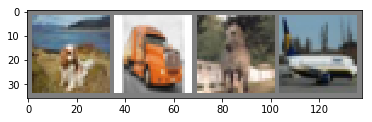

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

images, labels = iter(trainloader).next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 합성곱 신경망(CNN) 정의하기

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):      
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2,2) # padding = 0 -> 0으로 패딩된다.(크기감소x)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
net = Net()

## 손실 함수와 Optimizer 정의
- 손실 함수(교차 엔트로피), Optimizer(SGD)

In [6]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)
print(loss_func)
print('')
print(optimizer)

CrossEntropyLoss()

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


# 학습하기
- 효율적인 시간 관리를 위해 바로 CUDA로 실행

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    net.cuda()
else:
    device = torch.device('cpu')
print(device)
print(next(net.parameters()).is_cuda) # 내 모델이 cuda에 잘 올라갔는지 확인

cpu
False


In [8]:
for epoch in range(10):
    running_loss = 0.0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
#        inputs, labels = inputs.cuda(), labels.cuda() -> cuda가 있을 경우 사용
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('finish')

[1,  2000] loss: 2.094
[1,  4000] loss: 1.996
[1,  6000] loss: 1.943


KeyboardInterrupt: 

# 신경망 검사
- 예측한 결과와 답을 비교하는 방식

GroundTruth:    cat  ship  ship plane
Predicted:  truck truck truck truck


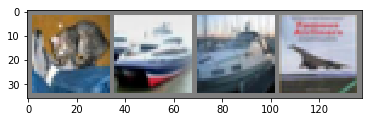

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
#        images, labels = images.cuda(), labels.cuda() -> cuda가 있을 경우 사용
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %
